## cleaned up notebook to convert this notebook into scripts

- last updated: 08/26/2024
- Yang-Joon Kim



In [1]:
# import libraries
import numpy as np
import scipy.sparse as sp
import pandas as pd
import scanpy as sc
import SEACells

# plotting modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [2]:
# define the utils function (plotting)
# SEACells.plot.plot_2D modified
def plot_2D_modified(
    ad,
    ax,
    key="X_umap",
    colour_metacells=True,
    title="Metacell Assignments",
    palette="Set2",
    SEACell_size=20,
    cell_size=10,
):
    """Plot 2D visualization of metacells using the embedding provided in 'key'.

    :param ad: annData containing 'Metacells' label in .obs
    :param ax: Axes object where the plot will be drawn
    :param key: (str) 2D embedding of data. Default: 'X_umap'
    :param colour_metacells: (bool) whether to colour cells by metacell assignment. Default: True
    :param title: (str) title for figure
    :param palette: (str) matplotlib colormap for metacells. Default: 'Set2'
    :param SEACell_size: (int) size of SEACell points
    :param cell_size: (int) size of cell points
    """
    umap = pd.DataFrame(ad.obsm[key]).set_index(ad.obs_names).join(ad.obs["SEACell"])
    umap["SEACell"] = umap["SEACell"].astype("category")
    mcs = umap.groupby("SEACell").mean().reset_index()

    if colour_metacells:
        sns.scatterplot(
            x=0, y=1, hue="SEACell", data=umap, s=cell_size, palette=sns.color_palette(palette), legend=None, ax=ax
        )
        sns.scatterplot(
            x=0,
            y=1,
            s=SEACell_size,
            hue="SEACell",
            data=mcs,
            palette=sns.color_palette(palette),
            edgecolor="black",
            linewidth=1.25,
            legend=None,
            ax=ax
        )
    else:
        sns.scatterplot(
            x=0, y=1, color="grey", data=umap, s=cell_size, legend=None, ax=ax
        )
        sns.scatterplot(
            x=0,
            y=1,
            s=SEACell_size,
            color="red",
            data=mcs,
            edgecolor="black",
            linewidth=1.25,
            legend=None,
            ax=ax
        )

    ax.set_xlabel(f"{key}-0")
    ax.set_ylabel(f"{key}-1")
    ax.set_title(title)
    ax.set_axis_off()

# SEACells.plot.plot_SEACell_sizes modified
def plot_SEACell_sizes_modified(
    ad,
    ax,
    save_as=None,
    show=True,
    title="Distribution of Metacell Sizes",
    bins=None,
    figsize=(5, 5),
):
    """Plot distribution of number of cells contained per metacell.

    :param ad: annData containing 'Metacells' label in .obs
    :param ax: Axes object where the plot will be drawn
    :param save_as: (str) path to which figure is saved. If None, figure is not saved.
    :param show: (bool) whether to show the plot
    :param title: (str) title of figure.
    :param bins: (int) number of bins for histogram
    :param figsize: (int,int) tuple of integers representing figure size
    :return: None.
    """
    assert "SEACell" in ad.obs, 'AnnData must contain "SEACell" in obs DataFrame.'
    label_df = ad.obs[["SEACell"]].reset_index()
    
    sns.histplot(label_df.groupby("SEACell").count().iloc[:, 0], bins=bins, ax=ax)
    sns.despine()
    ax.set_xlabel("Number of Cells per SEACell")
    ax.set_title(title)

    if save_as is not None:
        plt.savefig(save_as)
    if show:
        plt.show()
    plt.close()
    return pd.DataFrame(label_df.groupby("SEACell").count().iloc[:, 0]).rename(
        columns={"index": "size"}
    )

## re-computing the SEACells for NMP subsets ("X_lsi_integrated")

- (8/18/2024) We have tried to aggregate the cell-cell trans.probs using "Metacells", then projected the aggregated metacell-metacell trans.probs into 2D. This, however, looked very noisy - so, we're trying to troubleshoot this by re-computing the Metacells (SEACells) using the dim.reduction ("X_lsi_integrated") used for AlignedUMAP to use the same dim.reduction for (1) UMAP visualization.   

### Step 1. load the data

- load the NMP-subsetted adata
- load the "X_lsi_integrated", process it and add it to adata.obsm["X_lsi_integrated"]


In [3]:
# import the master_metadata (cell annotations, cell_ids from the integrated object)
master_metadata = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/master_rna_atac_metadata.csv", index_col=0)
master_metadata.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,dataset,integrated_weight,peaks_integrated_weight,wsnn_res_0_8,seurat_clusters,data_source,annotation_ML,scANVI_zscape,annotation_ML_coarse,dev_stage
AAACAGCCACCTAAGC-1_1,SeuratProject,6522.0,2317,21425.0,9781,0.571984,0.40,4.488213,0.48,5661.0,...,TDR118,4.062589e-01,0.593741,2,10,multiome,epidermis,contains head vasculature?,epidermis,15somites
AAACAGCCAGGGAGGA-1_1,SeuratProject,6100.0,2319,10334.0,5028,0.448143,0.13,4.795205,0.75,5553.0,...,TDR118,7.616462e-01,0.238354,8,16,multiome,pronephros,vascular smooth muscle,pronephros,15somites
AAACAGCCATAGACCC-1_1,SeuratProject,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,TDR118,5.938950e-08,1.000000,6,14,multiome,hindbrain,fin bud mesoderm (pectoral),hindbrain,15somites
AAACATGCAAACTCAT-1_1,SeuratProject,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,TDR118,3.694048e-01,0.630595,0,0,multiome,spinal_cord,posterior spinal cord progenitors,spinal_cord,15somites
AAACATGCAAGGACCA-1_1,SeuratProject,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,TDR118,3.265597e-02,0.967344,23,3,multiome,neural_optic2,pharynx,neural_optic,15somites


In [4]:
# import the "X_lsi_integrated" from the integrated object
lsi_integrated = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_lsi.csv", index_col=0)
lsi_integrated

# filter out the "low_quality_cells"
lsi_integrated = lsi_integrated[lsi_integrated.index.isin(master_metadata.index)]
lsi_integrated.head()

,integratedlsi_1,integratedlsi_2,integratedlsi_3,integratedlsi_4,integratedlsi_5,integratedlsi_6,integratedlsi_7,integratedlsi_8,integratedlsi_9,integratedlsi_10,...,integratedlsi_41,integratedlsi_42,integratedlsi_43,integratedlsi_44,integratedlsi_45,integratedlsi_46,integratedlsi_47,integratedlsi_48,integratedlsi_49,integratedlsi_50
AAACAGCCACCTAAGC-1_1,-0.158541,-0.859215,2.383088,0.959107,2.666897,-1.699729,1.353891,-1.151889,-0.356146,0.117458,...,-3.566609,-0.934853,0.099280,0.002932,-0.302558,2.392025,-0.260764,-2.388533,0.076997,-0.692057
AAACAGCCAGGGAGGA-1_1,0.274469,-0.804502,0.145722,-0.406308,0.475707,1.047771,-0.074658,-0.755766,-0.035674,1.429914,...,1.334581,1.780359,1.075075,-0.016776,-1.261588,-1.826283,0.197267,0.936461,-1.053473,1.443473
AAACAGCCATAGACCC-1_1,-1.277847,1.424970,-1.340787,-0.917404,1.769696,0.636748,0.634659,-0.712751,-0.582033,-1.482544,...,0.424773,0.786675,-1.264275,2.783100,-0.483104,-0.868756,-0.166610,-2.258445,-1.004266,-1.769703
AAACATGCAAACTCAT-1_1,-0.236289,0.104044,-1.128835,1.334319,0.830425,1.517093,0.124041,0.972479,-0.610059,0.355354,...,-1.797116,0.603657,-1.548172,-0.521610,0.461745,-0.114524,1.027203,-0.292045,1.993633,1.053841
AAACATGCAAGGACCA-1_1,1.233376,1.066662,-0.329429,-0.052175,-0.127930,-0.366875,0.684775,-0.888543,-0.049728,0.296817,...,1.197450,-1.021409,0.124640,-0.110493,-1.099886,0.903956,0.246317,-0.222636,-0.389359,1.504342


### subset the lsi_integrated using "data_id"

In [18]:
# input argument: "data_id"
data_id = "TDR126"

# subset the metadata (per dataset)
metadata_sub = master_metadata[master_metadata.dataset==data_id]
metadata_sub

# subset integrated_lsi (per dataset - using the indices from the above)
lsi_integrated_sub = lsi_integrated[lsi_integrated.index.isin(metadata_sub.index)]
lsi_integrated_sub.head()

,integratedlsi_1,integratedlsi_2,integratedlsi_3,integratedlsi_4,integratedlsi_5,integratedlsi_6,integratedlsi_7,integratedlsi_8,integratedlsi_9,integratedlsi_10,...,integratedlsi_41,integratedlsi_42,integratedlsi_43,integratedlsi_44,integratedlsi_45,integratedlsi_46,integratedlsi_47,integratedlsi_48,integratedlsi_49,integratedlsi_50
AAACAGCCAAACGGGC-1_5,-1.521314,-0.075265,-0.373258,1.510483,0.456118,0.389301,-1.616254,1.540393,-0.286396,0.096098,...,-2.240386,-0.265878,-0.912065,0.237626,-0.426609,-0.033757,-0.157777,-0.438508,0.880171,0.905780
AAACAGCCAACACTTG-1_5,-1.055886,-0.557285,-1.327737,1.579689,0.592907,1.704086,-0.483551,0.966131,-1.248257,0.456136,...,-2.911024,0.518442,-1.328137,-1.408637,0.555735,-0.322043,0.892761,0.007508,1.953888,1.241612
AAACAGCCACAATGCC-1_5,-0.237037,-1.622165,-1.830658,-1.548354,0.470460,-1.732987,0.727251,0.597946,0.266409,0.339992,...,-1.076362,1.576726,0.410522,-0.580851,-0.608723,1.708103,0.457425,0.693690,-0.398243,0.983978
AAACAGCCACCTGGTG-1_5,-0.482677,1.517905,-0.695081,-0.165816,1.303114,1.027717,0.819628,-0.122636,0.690683,-0.597507,...,-0.006730,1.217458,-0.643972,0.895693,0.255995,-0.557079,-0.024095,-0.115123,0.663533,0.549329
AAACAGCCAGTTATCG-1_5,0.480170,-0.698927,-0.968612,0.987549,0.143387,0.831965,-0.269622,-0.981352,-0.286430,-0.092169,...,-0.799245,0.431475,0.245352,0.143833,-0.910863,1.036117,0.879833,0.409198,-0.535268,-0.201429


In [19]:
# Load the cells-by-genes dataset (one timepoint)
adata = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/TDR126_nmps_manual_annotation.h5ad")
adata

AnnData object with n_obs × n_vars = 4602 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_umap_aligned', 'X_wnn.umap'

In [25]:
lsi_integrated_sub = lsi_integrated_sub[lsi_integrated_sub.index.isin(adata.obs_names)]
lsi_integrated_sub.head()

,integratedlsi_1,integratedlsi_2,integratedlsi_3,integratedlsi_4,integratedlsi_5,integratedlsi_6,integratedlsi_7,integratedlsi_8,integratedlsi_9,integratedlsi_10,...,integratedlsi_41,integratedlsi_42,integratedlsi_43,integratedlsi_44,integratedlsi_45,integratedlsi_46,integratedlsi_47,integratedlsi_48,integratedlsi_49,integratedlsi_50
AAACAGCCAACACTTG-1_5,-1.055886,-0.557285,-1.327737,1.579689,0.592907,1.704086,-0.483551,0.966131,-1.248257,0.456136,...,-2.911024,0.518442,-1.328137,-1.408637,0.555735,-0.322043,0.892761,0.007508,1.953888,1.241612
AAACAGCCACAATGCC-1_5,-0.237037,-1.622165,-1.830658,-1.548354,0.470460,-1.732987,0.727251,0.597946,0.266409,0.339992,...,-1.076362,1.576726,0.410522,-0.580851,-0.608723,1.708103,0.457425,0.693690,-0.398243,0.983978
AAACAGCCACCTGGTG-1_5,-0.482677,1.517905,-0.695081,-0.165816,1.303114,1.027717,0.819628,-0.122636,0.690683,-0.597507,...,-0.006730,1.217458,-0.643972,0.895693,0.255995,-0.557079,-0.024095,-0.115123,0.663533,0.549329
AAACAGCCAGTTATCG-1_5,0.480170,-0.698927,-0.968612,0.987549,0.143387,0.831965,-0.269622,-0.981352,-0.286430,-0.092169,...,-0.799245,0.431475,0.245352,0.143833,-0.910863,1.036117,0.879833,0.409198,-0.535268,-0.201429
AAACATGCAAACTGCC-1_5,1.589143,-0.668376,-1.014115,0.116159,0.048267,-0.281489,0.171433,-1.012903,0.440552,-0.178075,...,0.134346,0.362671,-0.725136,-0.317349,-0.227130,0.032559,0.283795,-0.330683,0.348066,0.184622


In [21]:
# drop the 1st LSI component
lsi_integrated_sub_filtered = lsi_integrated_sub.drop("integratedlsi_1", axis=1)
lsi_integrated_sub_filtered

,integratedlsi_2,integratedlsi_3,integratedlsi_4,integratedlsi_5,integratedlsi_6,integratedlsi_7,integratedlsi_8,integratedlsi_9,integratedlsi_10,integratedlsi_11,...,integratedlsi_41,integratedlsi_42,integratedlsi_43,integratedlsi_44,integratedlsi_45,integratedlsi_46,integratedlsi_47,integratedlsi_48,integratedlsi_49,integratedlsi_50
AAACAGCCAACACTTG-1_5,-0.557285,-1.327737,1.579689,0.592907,1.704086,-0.483551,0.966131,-1.248257,0.456136,0.910400,...,-2.911024,0.518442,-1.328137,-1.408637,0.555735,-0.322043,0.892761,0.007508,1.953888,1.241612
AAACAGCCACAATGCC-1_5,-1.622165,-1.830658,-1.548354,0.470460,-1.732987,0.727251,0.597946,0.266409,0.339992,-0.425384,...,-1.076362,1.576726,0.410522,-0.580851,-0.608723,1.708103,0.457425,0.693690,-0.398243,0.983978
AAACAGCCACCTGGTG-1_5,1.517905,-0.695081,-0.165816,1.303114,1.027717,0.819628,-0.122636,0.690683,-0.597507,-0.732501,...,-0.006730,1.217458,-0.643972,0.895693,0.255995,-0.557079,-0.024095,-0.115123,0.663533,0.549329
AAACAGCCAGTTATCG-1_5,-0.698927,-0.968612,0.987549,0.143387,0.831965,-0.269622,-0.981352,-0.286430,-0.092169,0.648067,...,-0.799245,0.431475,0.245352,0.143833,-0.910863,1.036117,0.879833,0.409198,-0.535268,-0.201429
AAACATGCAAACTGCC-1_5,-0.668376,-1.014115,0.116159,0.048267,-0.281489,0.171433,-1.012903,0.440552,-0.178075,0.055004,...,0.134346,0.362671,-0.725136,-0.317349,-0.227130,0.032559,0.283795,-0.330683,0.348066,0.184622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTAACGTGC-1_5,0.952410,-0.465273,-0.209537,1.433910,1.052763,0.284188,0.731651,-0.951602,-0.325139,0.045936,...,-0.188698,0.470674,0.216360,-0.012984,0.017365,0.373382,-0.761435,0.038247,-0.333142,-0.610109
TTTGTTGGTCCTAAGA-1_5,-1.769770,-1.956415,-0.639827,-0.168443,-1.163242,0.158395,-0.415034,0.201233,-0.305798,-0.417737,...,-1.266166,1.305061,-0.097074,-0.360991,-0.765289,0.718424,0.947895,-0.629230,-0.262885,-0.766281
TTTGTTGGTCTCAGCC-1_5,0.920585,-0.883852,0.033748,1.689671,1.181979,0.424933,0.975410,-1.003013,-0.057934,0.415723,...,0.300510,-0.243348,0.501249,1.361424,-0.128597,1.428185,0.071524,0.177379,-1.145680,-0.564911
TTTGTTGGTGAGCAAG-1_5,-1.337232,-1.548001,0.474639,-0.132160,-0.215670,-0.057747,-1.346043,0.422598,-0.461083,0.065506,...,0.118022,0.450773,-0.845571,-0.419373,-0.042227,0.350326,0.847826,-0.838342,0.466048,0.343106


In [23]:
lsi_integrated_sub_filtered

# Reorder df1 to match df2's index
lsi_integrated_sub_filtered = lsi_integrated_sub_filtered.reindex(adata.obs.index)
lsi_integrated_sub_filtered.head()

,integratedlsi_2,integratedlsi_3,integratedlsi_4,integratedlsi_5,integratedlsi_6,integratedlsi_7,integratedlsi_8,integratedlsi_9,integratedlsi_10,integratedlsi_11,...,integratedlsi_41,integratedlsi_42,integratedlsi_43,integratedlsi_44,integratedlsi_45,integratedlsi_46,integratedlsi_47,integratedlsi_48,integratedlsi_49,integratedlsi_50
AAACAGCCAACACTTG-1_5,-0.557285,-1.327737,1.579689,0.592907,1.704086,-0.483551,0.966131,-1.248257,0.456136,0.910400,...,-2.911024,0.518442,-1.328137,-1.408637,0.555735,-0.322043,0.892761,0.007508,1.953888,1.241612
AAACAGCCACAATGCC-1_5,-1.622165,-1.830658,-1.548354,0.470460,-1.732987,0.727251,0.597946,0.266409,0.339992,-0.425384,...,-1.076362,1.576726,0.410522,-0.580851,-0.608723,1.708103,0.457425,0.693690,-0.398243,0.983978
AAACAGCCACCTGGTG-1_5,1.517905,-0.695081,-0.165816,1.303114,1.027717,0.819628,-0.122636,0.690683,-0.597507,-0.732501,...,-0.006730,1.217458,-0.643972,0.895693,0.255995,-0.557079,-0.024095,-0.115123,0.663533,0.549329
AAACAGCCAGTTATCG-1_5,-0.698927,-0.968612,0.987549,0.143387,0.831965,-0.269622,-0.981352,-0.286430,-0.092169,0.648067,...,-0.799245,0.431475,0.245352,0.143833,-0.910863,1.036117,0.879833,0.409198,-0.535268,-0.201429
AAACATGCAAACTGCC-1_5,-0.668376,-1.014115,0.116159,0.048267,-0.281489,0.171433,-1.012903,0.440552,-0.178075,0.055004,...,0.134346,0.362671,-0.725136,-0.317349,-0.227130,0.032559,0.283795,-0.330683,0.348066,0.184622


In [28]:
adata.obsm["X_lsi_integrated"] = lsi_integrated_sub_filtered.iloc[:,0:39].to_numpy()
adata

AnnData object with n_obs × n_vars = 4602 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_umap_aligned', 'X_wnn.umap'

In [234]:
# # computing the nearest-neighborhood using the "integrated_lsi"
# sc.pp.neighbors(adata, use_rep="X_lsi_integrated")
# adata

AnnData object with n_obs × n_vars = 4602 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors', 'neighbors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_umap_aligned',

In [235]:
# # reformat the adata.obs_names (strip off the "_N")
# adata.obs_names = [s[0] for s in adata.obs_names.str.split("_")]
# adata.obs.head()

,orig_ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS_enrichment,TSS_percentile,nCount_SCT,...,peaks_integrated_weight,wsnn_res_0_8,seurat_clusters,data_source,annotation_ML,scANVI_zscape,annotation_ML_coarse,dev_stage,timepoints,manual_annotation
AAACAGCCAACACTTG-1,SeuratProject,3834.0,1637,36594.0,16160,0.853561,0.63,4.182484,0.11,3246.0,...,0.525524,0,0,multiome,spinal_cord,pronephric podocyte,spinal_cord,0somites,0somites,spinal_cord
AAACAGCCACAATGCC-1,SeuratProject,2593.0,1296,29241.0,12654,0.816789,0.48,4.942979,0.82,2701.0,...,0.567209,12,2,multiome,PSM,slow-committed myocyte,PSM,0somites,0somites,PSM
AAACAGCCACCTGGTG-1,SeuratProject,2632.0,1152,30638.0,13500,0.853846,0.63,4.093974,0.07,2736.0,...,0.589761,35,5,multiome,neural_posterior,pronephric podocyte,neural_posterior,0somites,0somites,neural_posterior
AAACAGCCAGTTATCG-1,SeuratProject,2578.0,1198,10486.0,5191,0.840000,0.58,4.407357,0.29,2703.0,...,0.531787,1,1,multiome,NMPs,fin bud mesoderm (pectoral),NMPs,0somites,0somites,NMPs
AAACATGCAAACTGCC-1,SeuratProject,2112.0,876,3866.0,1993,0.878613,0.73,4.577241,0.47,2567.0,...,0.414740,12,2,multiome,PSM,fin bud mesoderm (pectoral),PSM,0somites,0somites,PSM


In [28]:
# Step 2. pre-proecessing
# NOTE. Make sure that we have "raw" counts for SEACells (adata.X)
# NOTE. The Seurat/Signac pipeline results in a RDS file. Seurat-disk library's Convert function saves "data" to adata.X, and "counts" to adata.raw.X
# So, we will recover the raw counts to adata.X
adata.X = adata.layers["counts"]
# adata.X = adata.raw.X.copy()

In [30]:
adata

AnnData object with n_obs × n_vars = 4602 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage', 'timepoints', 'manual_annotation'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_umap_aligned', 'X_wnn.umap'

In [83]:
# Step 3. compute Metacells
# First, as a rule of thumb, we follow the recommendation by the SEACells authors,
# which is assigning one metacell for every 75 single-cells.
## User defined parameters

## Core parameters 
n_SEACells = np.floor((adata.n_obs)/30)
build_kernel_on = 'X_lsi_integrated' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_pca' for RNA data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

# set up the model
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

# run the model
model.construct_kernel_matrix()
M = model.kernel_matrix

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/4602 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/4602 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/4602 [00:00<?, ?it/s]

Constructing CSR matrix...


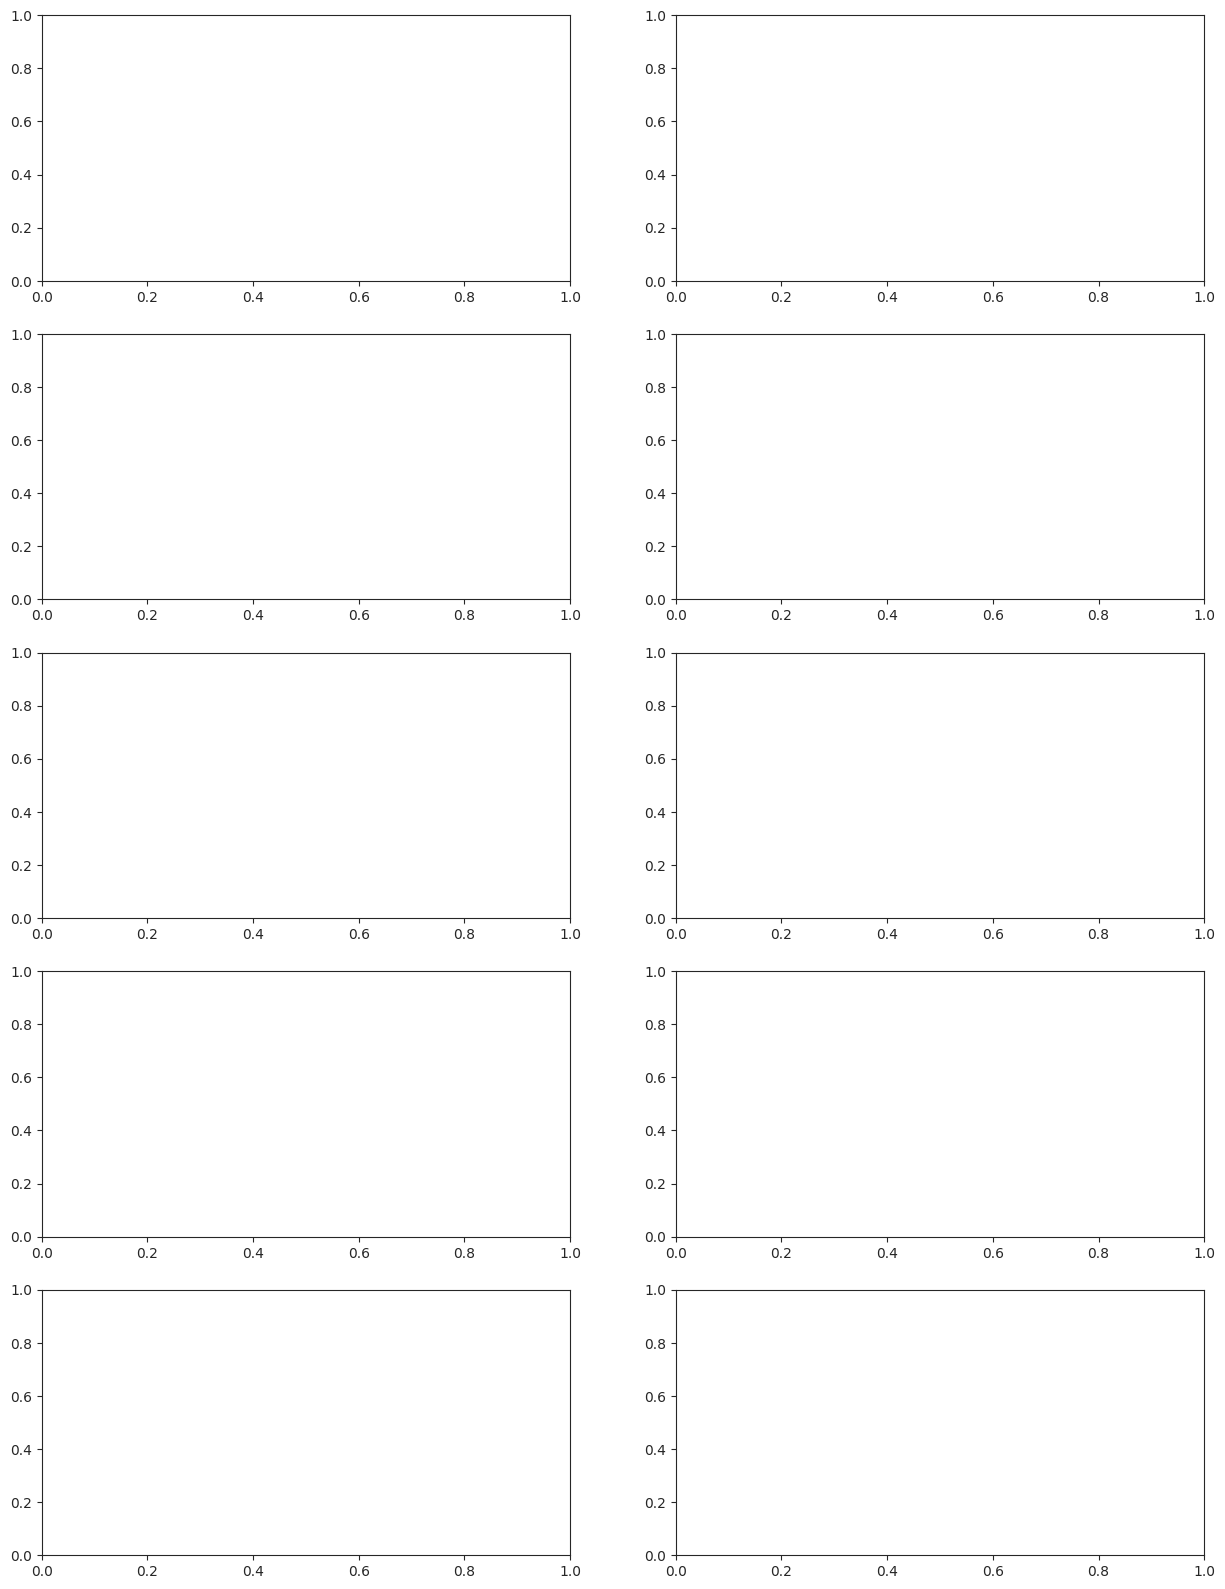

In [84]:
# Some plotting aesthetics
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

# Figure setup (a large figure containing all plots together)
# Initialize the figure and subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjust the size as needed

/home/yang-joon.kim/.local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


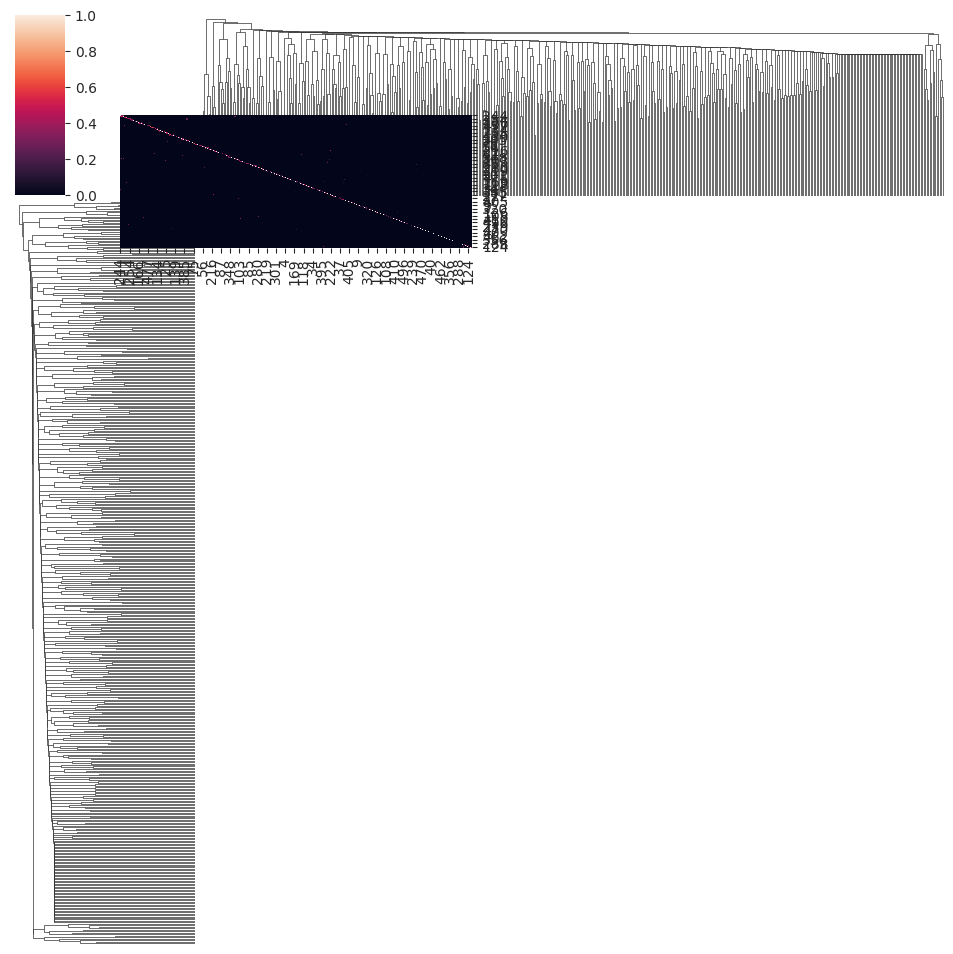

In [85]:
# plot the clustered heatmap of the kernel matrix
# sns.clustermap(M.toarray()[:500,:500], ax=axs[0, 0])
# Plot clustermap separately and extract the figure
clustermap = sns.clustermap(M.toarray()[:500,:500])
# Manually position the clustermap into the subplot layout
clustermap_ax = clustermap.ax_heatmap
clustermap_ax.set_position([axs[0, 0].get_position().x0, axs[0, 0].get_position().y0, axs[0, 0].get_position().width, axs[0, 0].get_position().height])
# axs[0, 0].remove()  # Remove the placeholder subplot

Building kernel on X_lsi_integrated
Computing diffusion components from X_lsi_integrated for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 147 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 284.22it/s]

Selecting 6 cells from greedy initialization.


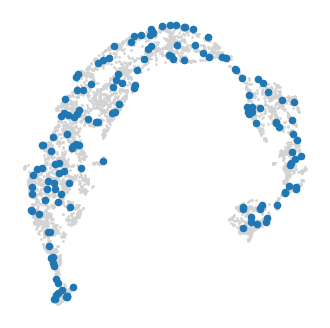

Randomly initialized A matrix.
Setting convergence threshold at 0.00109
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 44 iterations.


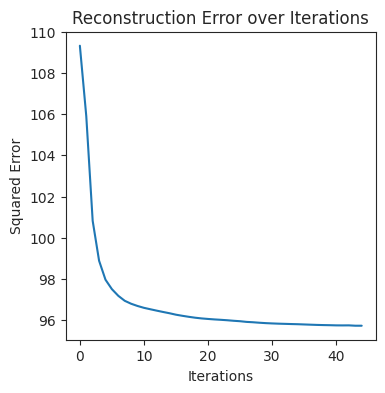

In [86]:
# Initialize archetypes
model.initialize_archetypes()

# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata, model,plot_basis="X_umap_aligned")

model.fit(min_iter=10, max_iter=100)
# Check for convergence 
model.plot_convergence()

In [87]:
# a histogram of the metacell sizes (number of cells per metacell)
axs[1, 0].hist(adata.obs.SEACell.value_counts())
axs[1, 0].set_xlabel("cell counts/metacell")
axs[1, 0].set_ylabel("counts")

# SEACElls model QC metric
# plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False, ax=axs[1, 1])
axs[1, 1].set_title(f'Non-trivial (> 0.1) assignments per cell')
axs[1, 1].set_xlabel('# Non-trivial SEACell Assignments')
axs[1, 1].set_ylabel('# Cells')
# plt.show()

# plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:, -5:])[:, ::-1], cmap='viridis', vmin=0, ax=axs[2, 0])
axs[2, 0].set_title('Strength of top 5 strongest assignments')
axs[2, 0].set_xlabel('$n^{th}$ strongest assignment')
# plt.show()

/tmp/ipykernel_339802/3994768692.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False, ax=axs[1, 1])


Text(0.5, 827.9636015325672, '$n^{th}$ strongest assignment')

In [88]:
# Step 5. visualize the results
# Plot the metacell assignments without coloring metacells
plot_2D_modified(adata, ax=axs[2, 1], key='X_umap_aligned', colour_metacells=False)

# Plot the metacell assignments with coloring metacells
plot_2D_modified(adata, ax=axs[3, 0], key='X_umap_aligned', colour_metacells=True)

# Plot the metacell sizes
plot_SEACell_sizes_modified(adata, ax=axs[3, 1], bins=5)

/tmp/ipykernel_339802/3808031905.py:27: UserWarning: 
The palette list has fewer values (8) than needed (153) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
/tmp/ipykernel_339802/3808031905.py:30: UserWarning: 
The palette list has fewer values (8) than needed (153) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Figure size 400x400 with 0 Axes>

,size
SEACell,
SEACell-0,10
SEACell-1,43
SEACell-10,31
SEACell-100,17
SEACell-101,46
...,...
SEACell-95,20
SEACell-96,21
SEACell-97,23


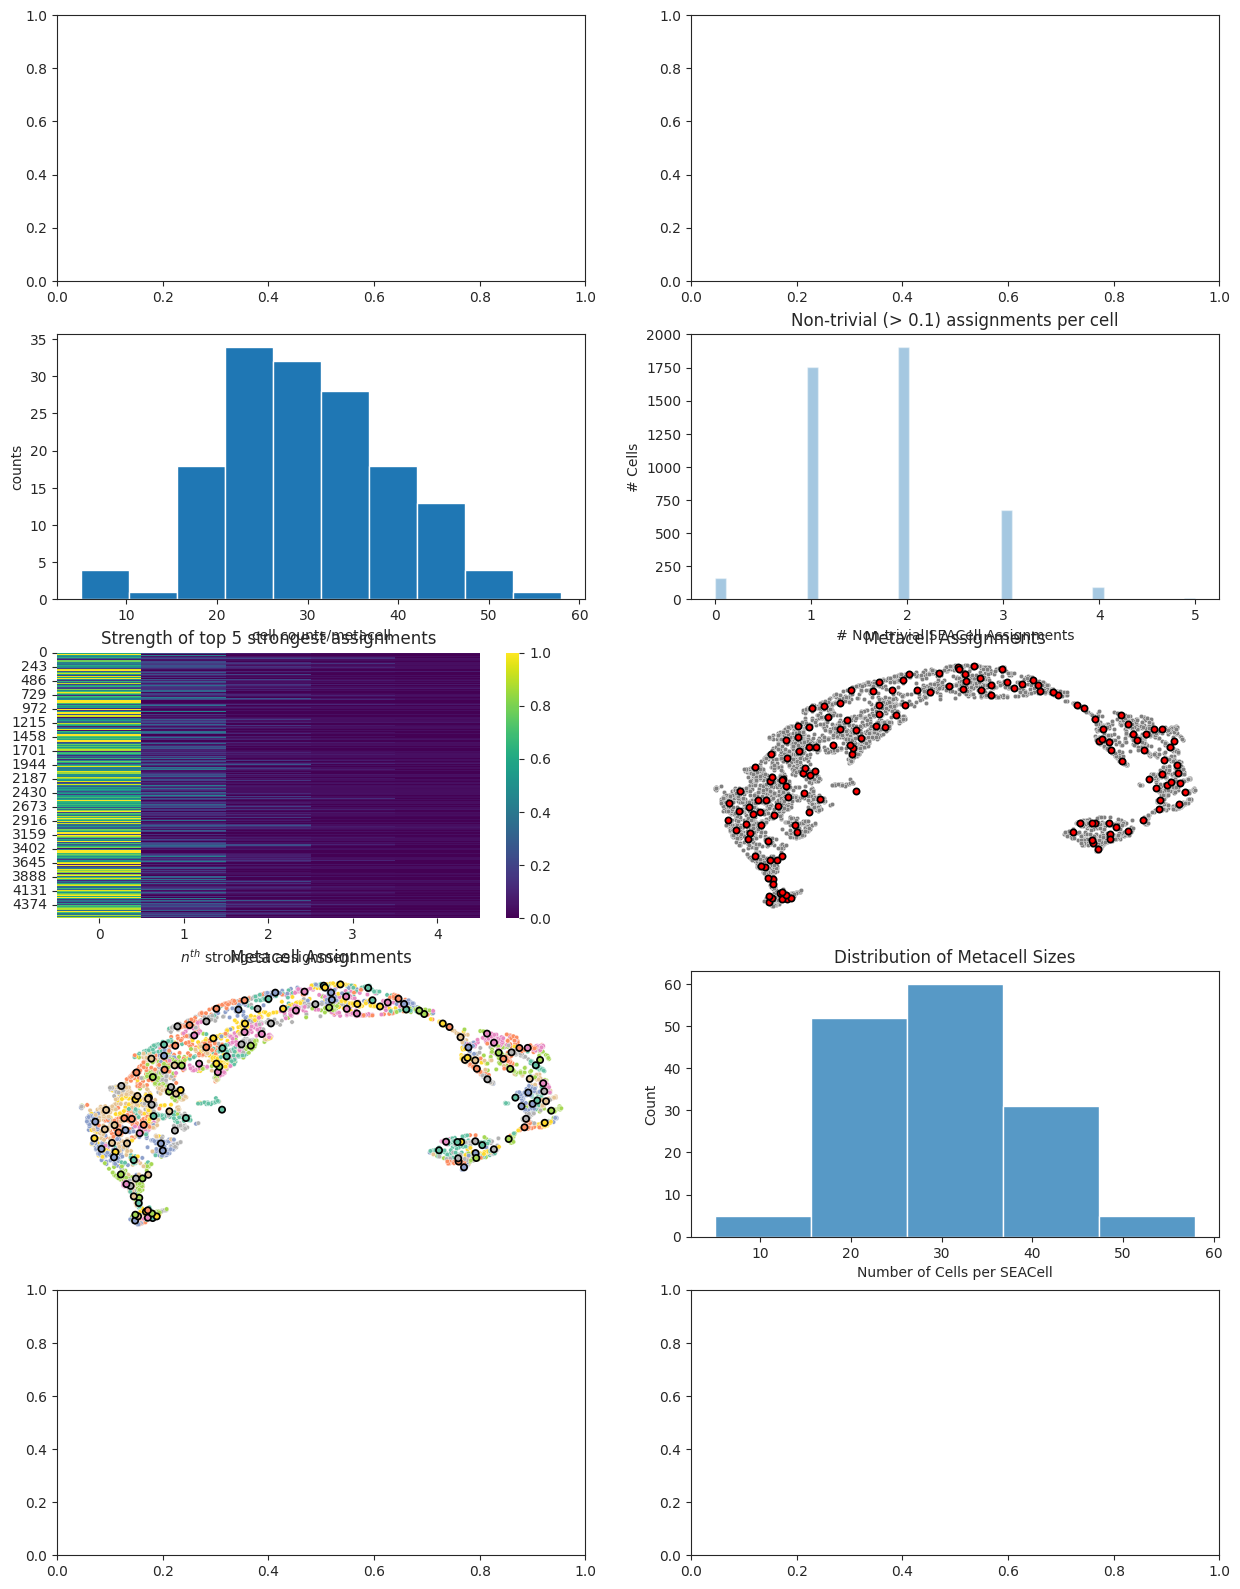

In [89]:
fig

In [43]:
# SEACell_purity

In [49]:
# annotation_class = "manual_annotation"
# f'{annotation_class}_purity'

'manual_annotation_purity'

In [90]:
annotation_class = "manual_annotation"

# Step 6. Quantifying the results (celltype_purity, compactness, etc.)
# Compute the celltype purity
SEACell_purity = SEACells.evaluate.compute_celltype_purity(adata, annotation_class)

sns.boxplot(data=SEACell_purity, y=f'{annotation_class}_purity', ax=axs[4, 0])
axs[4, 0].set_title('Celltype Purity')
sns.despine(ax=axs[4, 0])

# compute the compactness
compactness = SEACells.evaluate.compactness(adata, 'X_lsi_integrated')

sns.boxplot(data=compactness, y='compactness', ax=axs[4, 1])
axs[4, 1].set_title('Compactness')
sns.despine(ax=axs[4, 1])

# compute the separation
separation = SEACells.evaluate.separation(adata, 'X_lsi_integrated', nth_nbr=1)

sns.boxplot(data=separation, y='separation', ax=axs[0, 0])
axs[0, 0].set_title('Separation')
sns.despine(ax=axs[4, 1])

# Adjust spacing between plots using subplots_adjust
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Adjust spacing between plots
#plt.tight_layout()

<Figure size 400x400 with 0 Axes>

In [66]:
fig.tight_layout()
fig.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/seacells_nmp_subsets_timepoints/TDR126_X_lsi_integrated.png")
fig.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/seacells_nmp_subsets_timepoints/TDR126_X_lsi_integrated.pdf")

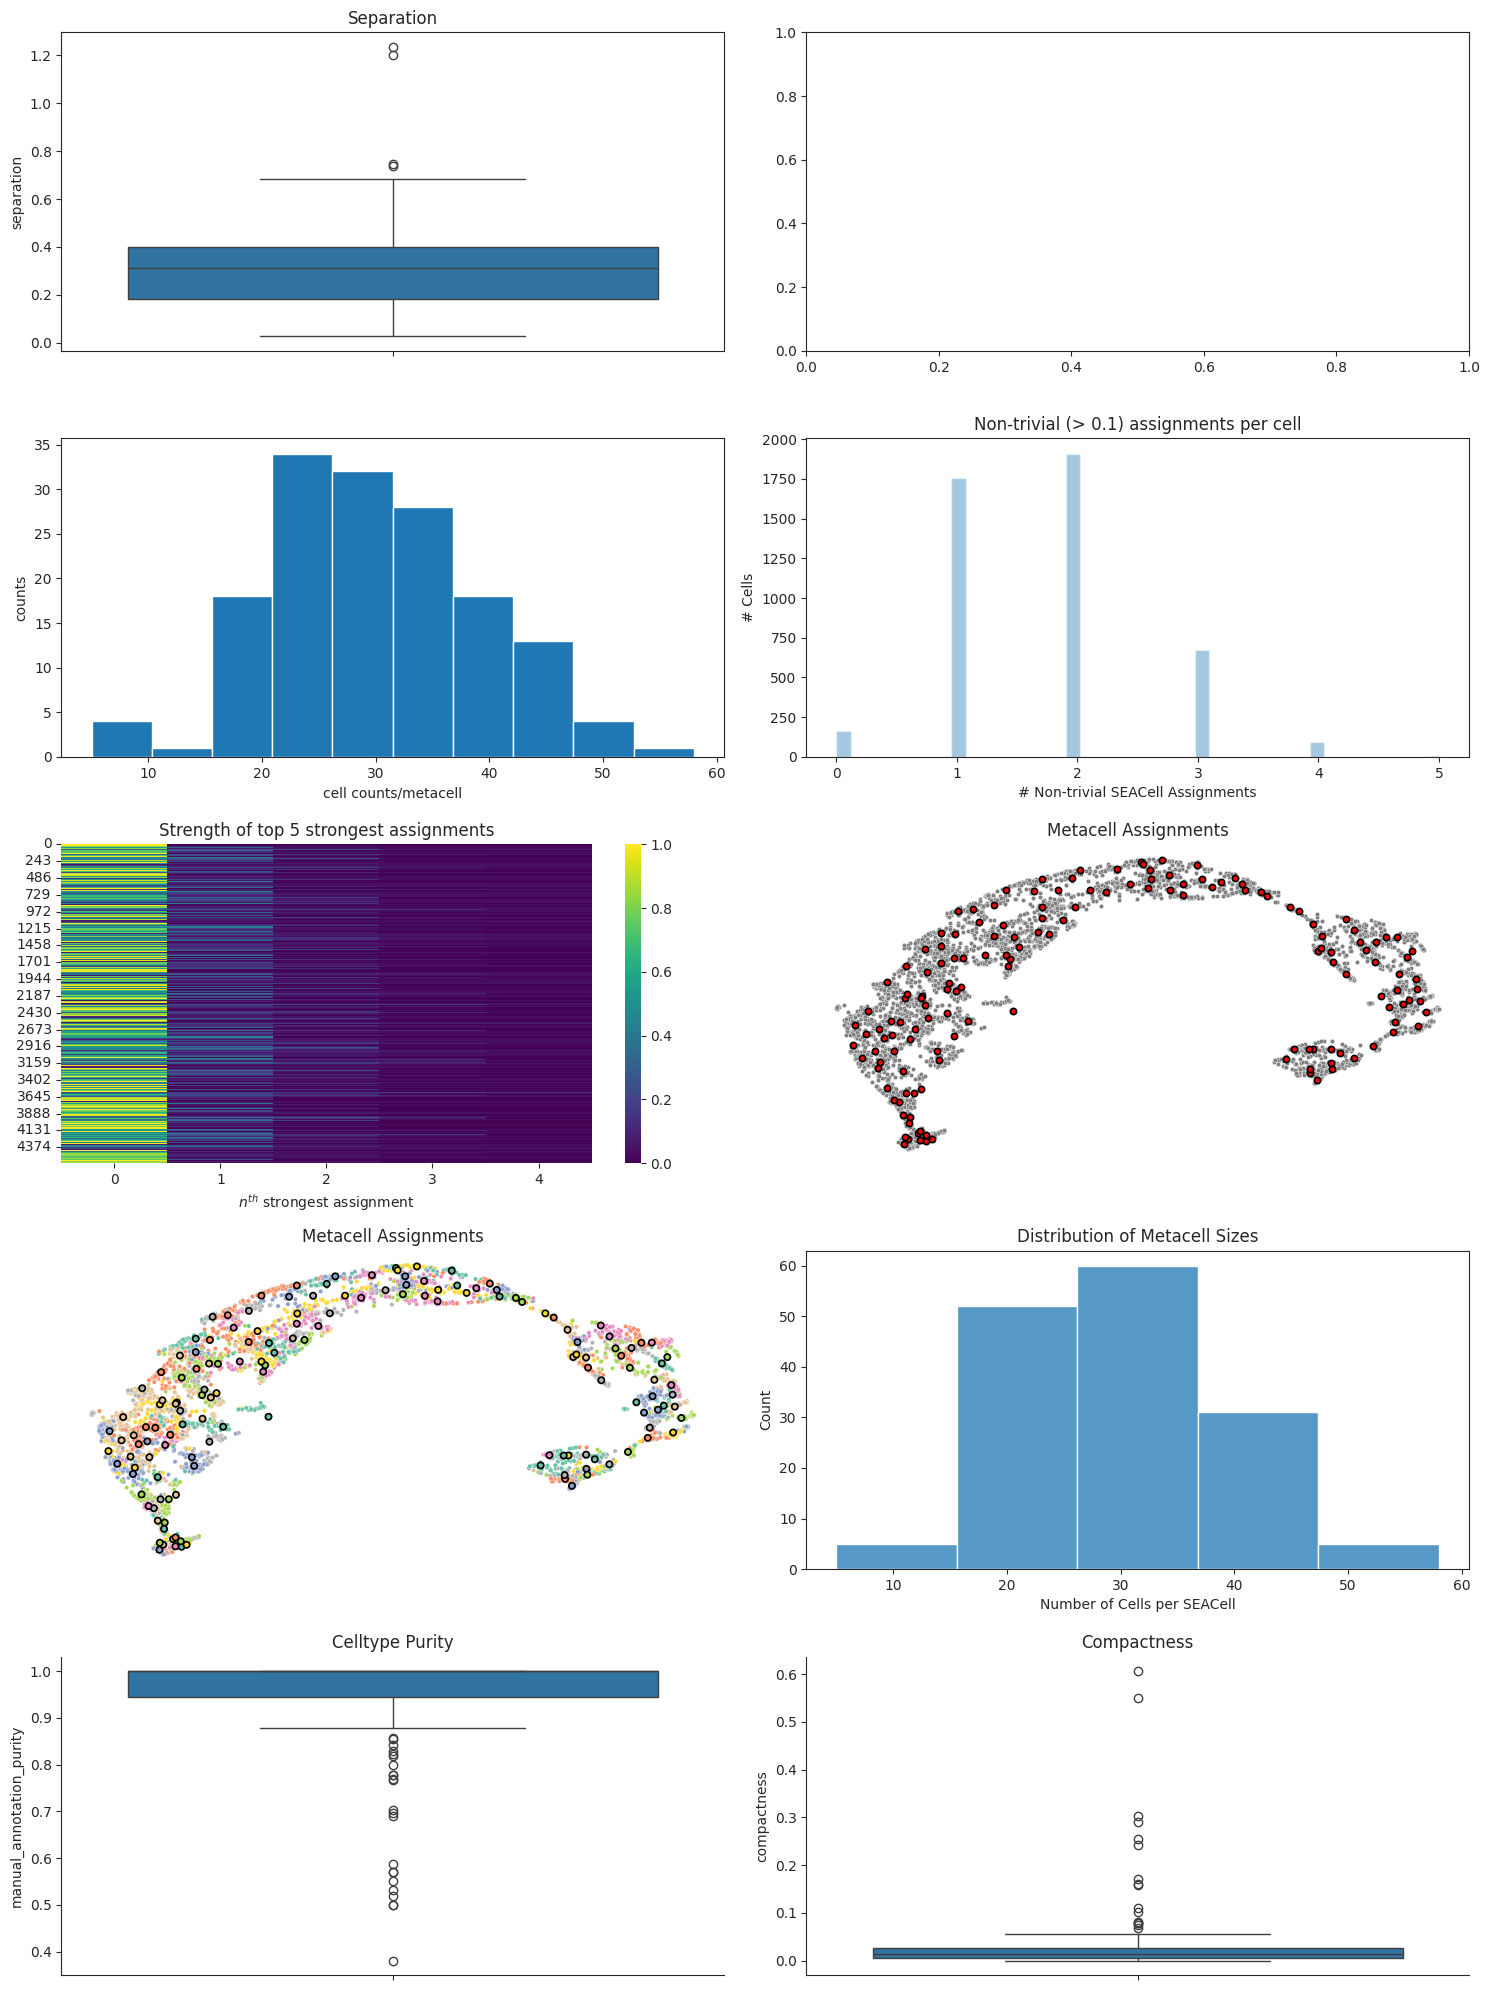

In [91]:
fig.tight_layout()
fig

### Optional - aggregating the adata using SEACells

- UMAP coordinates (averaged)
- most prevalent celltype

In [92]:
# save the obs field (cell_id:SEACell match)
adata.obs.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/09_NMPs_subsetted_v2/metacells/TDR126_seacells_lsi_integrated_obs_30cells.csv")